 ## 1. Theory: Quantile regression



 Instead of modelling the conditional **mean** of the spillover index given the exogenous variables

 (as in OLS), quantile regression models the conditional **quantiles**:



 $$

 Q_{S_t}(\tau \mid X_t) = \beta_0(\tau) + \beta_1(\tau) x_{1,t} + \dots + \beta_K(\tau) x_{K,t},

 $$



 where:



 * $S_t$ is the endogenous variable (e.g. total spillover, or “to others”, “from others”, etc.),

 * $x_{k,t}$ are exogenous regressors (CO₂/EUA, coal, TTF, …),

 * $\tau \in (0,1)$ is the quantile of interest (e.g. $\tau = 0.1, 0.5, 0.9$),

 * $\beta_k(\tau)$ are **quantile-specific** coefficients.



 For each quantile $\tau$, the estimator solves:



 $$

 \hat\beta(\tau)

   = \arg\min_{\beta} \sum_{t}

     \rho_\tau\big(S_t - X_t' \beta \big),

 $$



 where the **check loss** is



 $$

 \rho_\tau(u) = u \big( \tau - \mathbf{1}\{u < 0\} \big).

 $$



 Intuitively:



 * For $\tau = 0.5$, quantile regression estimates the **conditional median**.

 * For $\tau < 0.5$ (e.g. 0.1), it focuses on the **lower tail** (low spillover states).

 * For $\tau > 0.5$ (e.g. 0.9), it focuses on the **upper tail** (high spillover states).



 This allows us to see whether the impact of exogenous variables (fuel prices, RES, load, …)

 is different in calm vs stressed spillover regimes.



 Below, we implement this via `statsmodels.QuantReg`, running:



 * one regression per endogenous series,

 * for a **set of quantiles** (e.g. 0.1, 0.25, 0.5, 0.75, 0.9),

 * with a flexible set of exogenous variables (you can easily add/remove variables by editing `exog_cols`).

In [1]:
# Imports and paths

from pathlib import Path
from typing import Dict, List, Optional, Tuple

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Paths
OUT_DIR = Path("../data/endogenous/prices/differenced")
endog_path = OUT_DIR / "endogenous_tsi_diff.parquet"
exog_path = Path("../data/exogenous/all_exog_ready.parquet")



In [2]:
# Helper to load parquet and convert to wide format

def load_parquet_to_wide(
    path: Path,
    date_col: str = "date",
    series_col: str = "series",
    value_col: str = "value",
) -> pd.DataFrame:
    """
    Load a parquet file and return a wide DataFrame with a DatetimeIndex.

    If the file is in long format [date, series, value, ...], pivot to wide.
    If it's already wide with a 'date' column, just set 'date' as index.
    """
    df = pd.read_parquet(path)

    if {date_col, series_col, value_col}.issubset(df.columns):
        # Long format -> pivot to wide
        df[date_col] = pd.to_datetime(df[date_col])
        df_wide = (
            df.pivot(index=date_col, columns=series_col, values=value_col)
              .sort_index()
        )
    else:
        # Assume already wide with 'date' column
        if date_col not in df.columns:
            raise ValueError(
                f"'date' column not found in {path}. "
                "Add it or adapt `date_col` in load_parquet_to_wide()."
            )
        df = df.copy()
        df[date_col] = pd.to_datetime(df[date_col])
        df_wide = df.set_index(date_col).sort_index()

    df_wide.index = pd.to_datetime(df_wide.index)
    return df_wide



In [3]:
# Prepare regression data: align endogenous/exogenous and drop NAs

def prepare_regression_data(
    endog_path: Path,
    exog_path: Path,
    exog_cols: Optional[List[str]] = None,
) -> (pd.DataFrame, List[str], List[str]):
    """
    Load endogenous and exogenous data, align them and return:
      - merged DataFrame (index=date, columns=endog+exog),
      - list of endogenous column names,
      - list of exogenous column names actually used.
    """
    endog_wide = load_parquet_to_wide(endog_path)
    exog_wide = load_parquet_to_wide(exog_path)

    # Inner join on date to ensure common sample
    data = endog_wide.join(exog_wide, how="inner")

    endog_names = list(endog_wide.columns)

    if exog_cols is None:
        # Use all exogenous columns
        exog_names = [c for c in exog_wide.columns]
    else:
        # Only user-specified exogenous columns
        missing = [c for c in exog_cols if c not in exog_wide.columns]
        if missing:
            raise ValueError(
                f"The following exogenous columns are not in the exog data: {missing}"
            )
        exog_names = exog_cols

    data = data[endog_names + exog_names].dropna()

    return data, endog_names, exog_names



In [4]:
# Quantile regressions + coefficient table

def run_quantile_regressions(
    data: pd.DataFrame,
    endog_names: List[str],
    exog_names: List[str],
    quantiles: List[float],
) -> Dict[Tuple[str, float], sm.regression.linear_model.RegressionResultsWrapper]:
    """
    Run Quantile Regressions for each endogenous variable and each quantile.

    For each y in `endog_names` and each tau in `quantiles`:
        Q_{y_t}(tau | X_t) = beta0(tau) + beta(tau)' * x_t

    Returns
    -------
    results : dict
        Mapping (y_name, tau) -> statsmodels results object.
    """
    results = {}

    for y_col in endog_names:
        
        y = data[y_col]
        X = data[exog_names]
        X = sm.add_constant(X)

        model = sm.QuantReg(y, X)

        for tau in quantiles:
            res = model.fit(q=tau)
            results[(y_col, tau)] = res

    return results


def build_coef_table_qr(
    results: Dict[Tuple[str, float], sm.regression.linear_model.RegressionResultsWrapper],
    exog_names: List[str],
) -> pd.DataFrame:
    """
    Build a tidy coefficient table from a dict of Quantile Regression results.

    Columns: ['endog', 'quantile', 'variable', 'coef', 'std_err', 't', 'pval']
    """
    rows = []
    for (y_name, tau), res in results.items():
        for var in ["const"] + exog_names:
            rows.append(
                {
                    "endog": y_name,
                    "quantile": tau,
                    "variable": var,
                    "coef": res.params[var],
                    "std_err": res.bse[var],
                    "t": res.tvalues[var],
                    "pval": res.pvalues[var],
                }
            )

    coef_df = pd.DataFrame(rows)
    return coef_df



In [5]:
# Plot helper for one endogenous variable across quantiles

def plot_qr_coefficients_for_endog(
    coef_df: pd.DataFrame,
    endog_name: str,
    alpha: float = 0.05,
):
    """
    Plot quantile regression coefficients with (1 - alpha)*100% confidence intervals
    for one endogenous variable, across quantiles, for each exogenous regressor.

    Produces one line per exogenous variable (excluding the intercept),
    with quantile on the x-axis and coefficient on the y-axis.
    """
    subset = coef_df[coef_df["endog"] == endog_name].copy()
    subset = subset[subset["variable"] != "const"]  # skip intercept

    z = 1.96  # approx 95% CI

    fig, ax = plt.subplots(figsize=(8, 5))

    for var in subset["variable"].unique():
        tmp = subset[subset["variable"] == var].sort_values("quantile")
        coef = tmp["coef"].values
        se = tmp["std_err"].values
        q = tmp["quantile"].values

        lower = coef - z * se
        upper = coef + z * se

        ax.plot(q, coef, marker="o", label=var)
        ax.fill_between(q, lower, upper, alpha=0.15)

    ax.axhline(0.0, linestyle="--", linewidth=1)
    ax.set_title(f"Quantile regression coefficients for {endog_name}")
    ax.set_xlabel("Quantile (τ)")
    ax.set_ylabel("Coefficient")
    ax.legend()
    plt.tight_layout()
    plt.show()



Endogenous series: ['d_tsi_mhar_recov_neg', 'd_tsi_mhar_recov_pos', 'd_tsi_mhar_recov', 'd_tsi_mhar_revar']
Exogenous variables used: ['load_mean_mw_fr', 'load_mean_mw_pt', 'flow_mean_mw_es_pt', 'flow_mean_mw_pt_es', 'd_TTF', 'd_co2', 'd_coal', 'd_load_mean_mw_es', 'd_flow_mean_mw_es_fr', 'd_flow_mean_mw_fr_es', 'd_cac_eur_pts', 'd_ibex_eur_pts', 'd_psi_eur_pts', 'iberian_exception']
Final sample size: 1076


,endog,quantile,variable,coef,std_err,t,pval
0,d_tsi_mhar_recov_neg,0.10,const,-2.264316e-02,0.112434,-0.201391,0.840431
1,d_tsi_mhar_recov_neg,0.10,load_mean_mw_fr,-1.692779e-06,0.000002,-0.923634,0.355887
2,d_tsi_mhar_recov_neg,0.10,load_mean_mw_pt,-6.160633e-06,0.000027,-0.226907,0.820540
3,d_tsi_mhar_recov_neg,0.10,flow_mean_mw_es_pt,-2.074796e-05,0.000020,-1.037513,0.299733
4,d_tsi_mhar_recov_neg,0.10,flow_mean_mw_pt_es,-2.269171e-05,0.000032,-0.704501,0.481276
5,d_tsi_mhar_recov_neg,0.10,d_TTF,-3.557010e-03,0.003908,-0.910111,0.362971
6,d_tsi_mhar_recov_neg,0.10,d_co2,-3.425426e-04,0.006770,-0.050596,0.959657
7,d_tsi_mhar_recov_neg,0.10,d_coal,1.726313e-03,0.002918,0.591587,0.554253
8,d_tsi_mhar_recov_neg,0.10,d_load_mean_mw_es,8.422156e-06,0.000006,1.520529,0.128676
9,d_tsi_mhar_recov_neg,0.10,d_flow_mean_mw_es_fr,-5.198613e-07,0.000026,-0.019835,0.984179


Saved quantile regression coefficient table to: ..\data\endogenous\prices\differenced\quantile_regression_results.csv


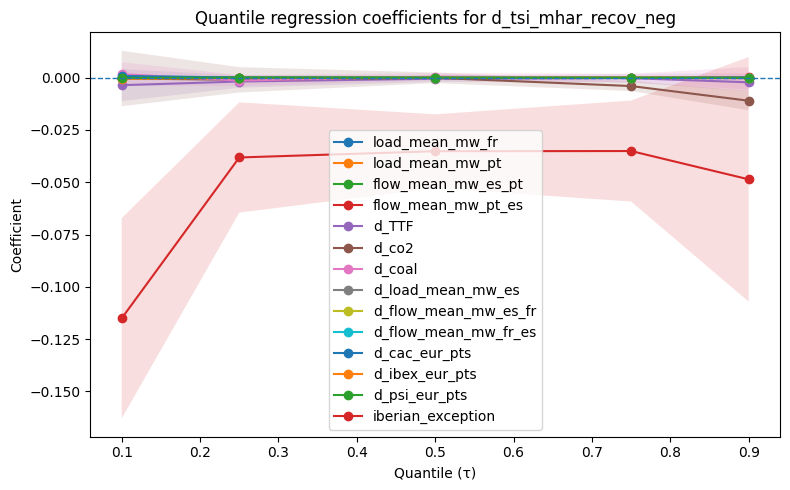

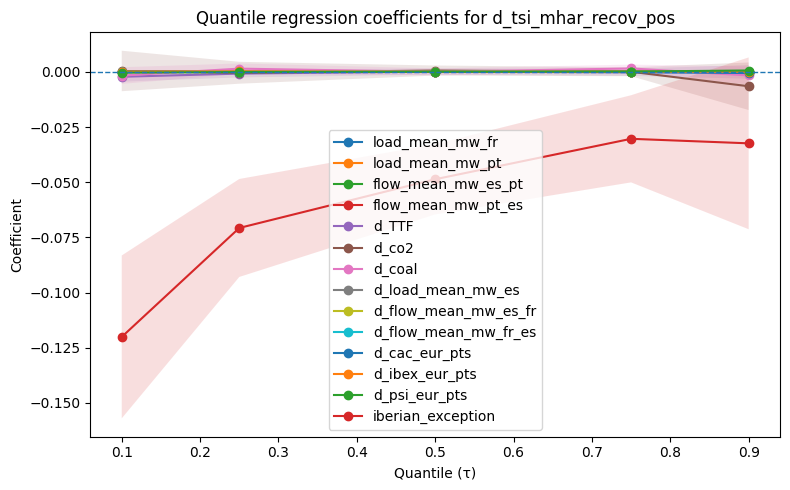

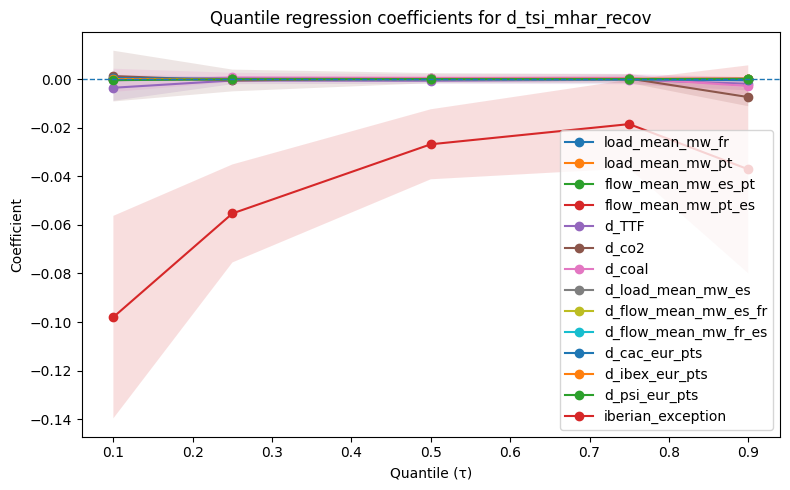

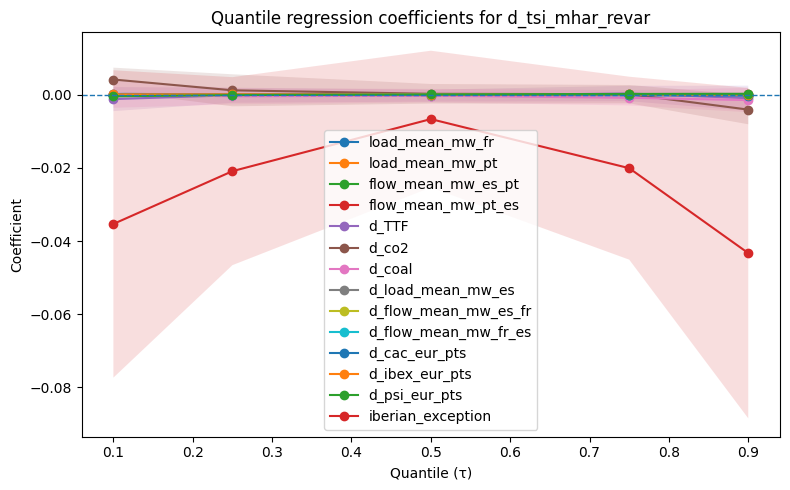

In [6]:
# Main workflow cell

# Choose which exogenous variables to use:
#   - Set exog_cols = None to use ALL exogenous columns from the parquet.
#   - Or specify a list, e.g. exog_cols = ["d_eua", "d_coal", "d_ttf"]
exog_cols = None

# Choose quantiles to estimate
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

# Load and prepare data
data, endog_names, exog_names = prepare_regression_data(
    endog_path=endog_path,
    exog_path=exog_path,
    exog_cols=exog_cols,
)

print("Endogenous series:", endog_names)
print("Exogenous variables used:", exog_names)
print("Final sample size:", len(data))

# Run quantile regressions
results_qr = run_quantile_regressions(
    data=data,
    endog_names=endog_names,
    exog_names=exog_names,
    quantiles=quantiles,
)

# Build coefficient table
coef_qr_df = build_coef_table_qr(results_qr, exog_names)
display(coef_qr_df.head(20))

# Save coefficient table
OUT_DIR.mkdir(parents=True, exist_ok=True)
out_coef_path_qr = OUT_DIR / "quantile_regression_results.csv"
coef_qr_df.to_csv(out_coef_path_qr, index=False)
print(f"Saved quantile regression coefficient table to: {out_coef_path_qr}")

# Example plots for each endogenous series
for y_name in endog_names:
    plot_qr_coefficients_for_endog(coef_qr_df, y_name)
